# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




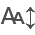

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag1mftakvrjmpfvp.allegrograph.cloud/repositories/judges"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/TanguyGodat/Judges/blob/main/graphs/wikidata_imported_data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))
          }
}
GROUP BY ?s
"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [8]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

29011


[['http://www.wikidata.org/entity/Q336459',
  'Geoffrey Lawrence, 1st Baron Oaksey',
  '1880',
  'male',
  'United Kingdom',
  'Europe',
  'politician, judge',
  ''],
 ['http://www.wikidata.org/entity/Q7422125',
  'Sarah Bradley',
  '1956',
  'female',
  'Australia',
  'Oceania',
  'judge',
  ''],
 ['http://www.wikidata.org/entity/Q55728795',
  'Roh Tae-ak',
  '1962',
  'male',
  'South Korea',
  'Asia',
  'judge',
  '']]

In [9]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,
3,http://www.wikidata.org/entity/Q1170754,Tielman Roos,1879,male,South Africa,Africa,"politician, judge, lawyer",
4,http://www.wikidata.org/entity/Q5080447,Charles M. Cooke,1844,male,United States,North America,"politician, judge, lawyer",


In [10]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [11]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29011 entries, 0 to 29010
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    29011 non-null  object
 1   personLabel  29011 non-null  object
 2   birthYear    29011 non-null  int64 
 3   gender       29011 non-null  object
 4   countries    29011 non-null  object
 5   continents   29011 non-null  object
 6   occupations  29011 non-null  object
 7   fields       29011 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.8+ MB


In [13]:
### Store to CSV
f_path = '../data/df_continent_occupations_fields_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [14]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0           Europe
1          Oceania
2             Asia
3           Africa
4    North America
Name: continents, dtype: object


In [15]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                            0
continents                   
Europe                  12962
North America           10751
Asia                     2705
South America             926
Africa                    656
Oceania                   561
Asia, Europe              107
Asia, Africa, Europe       85
Eurasia, North America     71
North America, Europe      33


In [16]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [17]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [18]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,,Asia


In [19]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Eurasia             83
Oceania            565
Africa             670
SouthAmerica       926
Asia              2705
NorthAmerica     10773
Europe           13289


In [20]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
169,http://www.wikidata.org/entity/Q9382148,Władysław Nowca,1846,male,"Congress Poland, Russian Empire","Europe, Eurasia, North America","politician, judge",,Europe
375,http://www.wikidata.org/entity/Q84761083,Q84761083,1970,male,"Soviet Union, Russia","Asia, Europe",judge,,Europe
526,http://www.wikidata.org/entity/Q4066631,Konstantin Annenkov,1843,male,Russian Empire,"Eurasia, North America","judge, scientist, jurist","civil law, jurisprudence, justice and judicial...",Eurasia
748,http://www.wikidata.org/entity/Q109486616,Q109486616,1875,male,"Russian Empire, Russian Socialist Federative S...","Eurasia, North America","teacher, legal counselor, judge",,Eurasia
833,http://www.wikidata.org/entity/Q65175922,Q65175922,1852,male,Russian Empire,"Eurasia, North America",judge,,Eurasia
1311,http://www.wikidata.org/entity/Q15824185,Konstantin von Kleist,1812,male,Russian Empire,"Eurasia, North America","jurist, judge",,Eurasia
1410,http://www.wikidata.org/entity/Q4154688,Yury Danilov,1950,male,Russia,Europe,judge,,Europe


In [21]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia         77
Europe         161


In [22]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q89272729,B. Sudheendra Kumar,1959,male,India,Asia,judge,,Asia
98,http://www.wikidata.org/entity/Q67138,Herbert Rosendorfer,1934,male,Germany,Europe,"poet lawyer, writer, screenwriter, judge",,Europe
99,http://www.wikidata.org/entity/Q24681310,Gösta Lind,1898,male,Sweden,Europe,judge,,Europe
100,http://www.wikidata.org/entity/Q106731059,John Pringle,1929,male,United Kingdom,Europe,judge,,Europe


In [23]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
111,http://www.wikidata.org/entity/Q7104084,Orrin Grimmell Judd,1906,male,United States,North America,"judge, lawyer",,NorthAmerica
112,http://www.wikidata.org/entity/Q16063851,Charles H. Walker,1828,male,United States,North America,"politician, judge, lawyer",,NorthAmerica
113,http://www.wikidata.org/entity/Q5482246,Francis R. E. Cornell,1821,male,United States,North America,"Minnesota Attorney General, politician, judge,...",,NorthAmerica
114,http://www.wikidata.org/entity/Q7411526,Samuel Grayson Wilson,1949,male,United States,North America,"judge, lawyer",,NorthAmerica
115,http://www.wikidata.org/entity/Q75548435,"Sir Harold Cassel, 3rd Baronet",1916,male,"United Kingdom, United Kingdom of Great Britai...",Europe,judge,,Europe
116,http://www.wikidata.org/entity/Q106828006,David Morton Jack,1935,male,United Kingdom,Europe,judge,,Europe
117,http://www.wikidata.org/entity/Q113574067,Lars Apostoli,1961,male,Kingdom of Denmark,Europe,judge,,Europe


In [24]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  29002 

0     http://www.wikidata.org/entity/Q336459
1    http://www.wikidata.org/entity/Q7422125
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,,Asia
3,http://www.wikidata.org/entity/Q1170754,Tielman Roos,1879,male,South Africa,Africa,"politician, judge, lawyer",,Africa
4,http://www.wikidata.org/entity/Q5080447,Charles M. Cooke,1844,male,United States,North America,"politician, judge, lawyer",,NorthAmerica


### Distribution des continents: représentation graphique

In [25]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Eurasia,83,0.29
Oceania,565,1.95
Africa,670,2.31
SouthAmerica,926,3.19
Asia,2705,9.32
NorthAmerica,10773,37.13
Europe,13289,45.81


In [26]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,Asia,SouthAmerica,Africa,Oceania,Eurasia
frequence,45.81,37.13,9.32,3.19,2.31,1.95,0.29


In [27]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


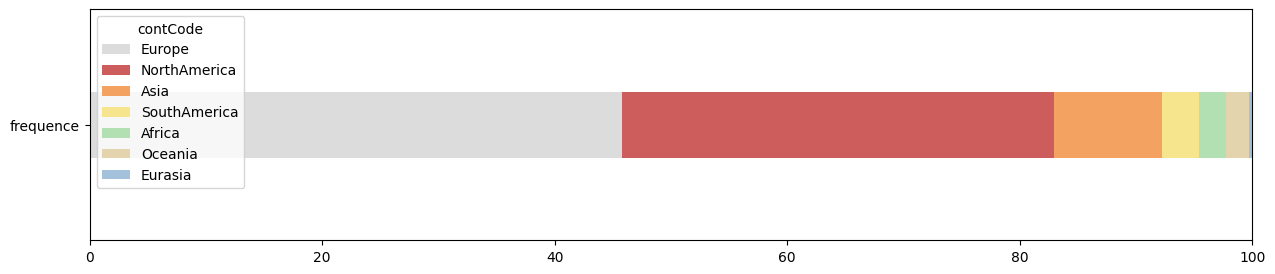

In [28]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [29]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1800, 2001, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1800, 1825, 1850, 1875, 1900] [1900, 1925, 1950, 1975, 2000] 8


In [30]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [31]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe,1875-1899
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania,1950-1974
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,,Asia,1950-1974


In [32]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=False).size()
print(naissances_per)

per_25
1800-1824    2355
1825-1849    2452
1850-1874    2808
1875-1899    3151
1900-1924    4540
1925-1949    7263
1950-1974    5985
1975-1999     384
dtype: int64


### Comparer période et continent

In [33]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1800-1824,9,5,21,942,1282,10,86,2355
1825-1849,9,57,32,960,1274,21,99,2452
1850-1874,20,144,17,1197,1303,33,94,2808
1875-1899,31,237,5,1527,1219,49,83,3151
1900-1924,75,426,0,2129,1658,102,150,4540
1925-1949,240,881,1,3420,2260,232,229,7263
1950-1974,257,923,5,2867,1638,117,178,5985
1975-1999,18,23,2,203,132,0,6,384
Total,659,2696,83,13245,10766,564,925,28938


In [34]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1800-1824,942,21,1282,5,9,10,86,2355
1825-1849,960,32,1274,57,9,21,99,2452
1850-1874,1197,17,1303,144,20,33,94,2808
1875-1899,1527,5,1219,237,31,49,83,3151
1900-1924,2129,0,1658,426,75,102,150,4540
1925-1949,3420,1,2260,881,240,232,229,7263
1950-1974,2867,5,1638,923,257,117,178,5985
1975-1999,203,2,132,23,18,0,6,384
Total,13245,83,10766,2696,659,564,925,28938


In [35]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


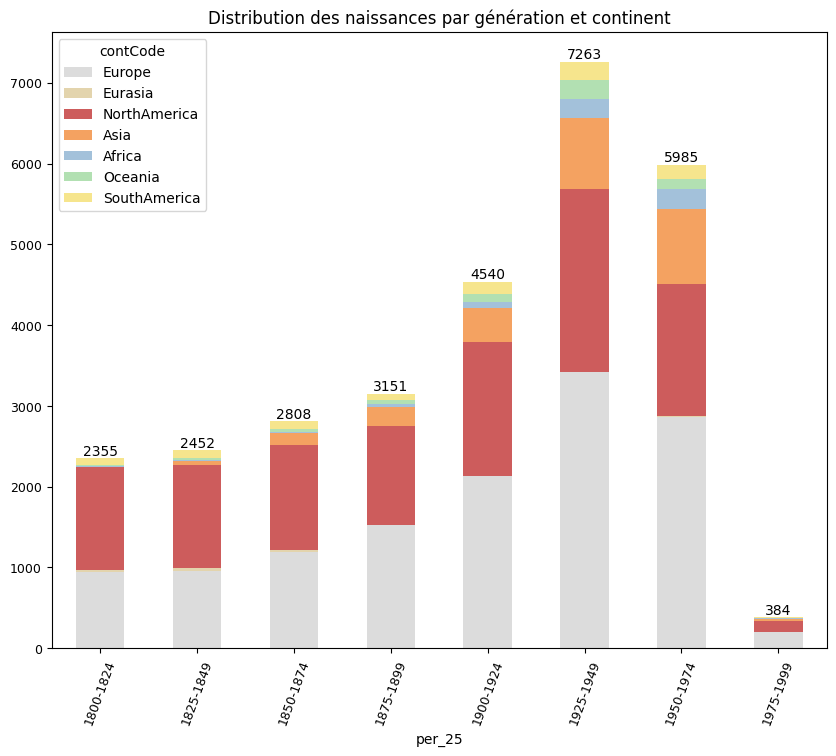

In [36]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [37]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1800-1824,942,21,1282,5,9,10,86,2355
1825-1849,960,32,1274,57,9,21,99,2452
1850-1874,1197,17,1303,144,20,33,94,2808
1875-1899,1527,5,1219,237,31,49,83,3151
1900-1924,2129,0,1658,426,75,102,150,4540
1925-1949,3420,1,2260,881,240,232,229,7263
1950-1974,2867,5,1638,923,257,117,178,5985
1975-1999,203,2,132,23,18,0,6,384
Total,13245,83,10766,2696,659,564,925,28938


In [97]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[:-1,:-1].copy(deep=True) #.iloc
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1800-1824,942,21,1282,5,9,10,86
1825-1849,960,32,1274,57,9,21,99
1850-1874,1197,17,1303,144,20,33,94
1875-1899,1527,5,1219,237,31,49,83
1900-1924,2129,0,1658,426,75,102,150
1925-1949,3420,1,2260,881,240,232,229
1950-1974,2867,5,1638,923,257,117,178
1975-1999,203,2,132,23,18,0,6


In [98]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 8 , 7 ), effectif: 28938 , nombre max. facteurs: 6


In [99]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 1995.85 , dof : 42
p-value : 0.0
phi2 = inertie (variance totale) : 0.06896987249550832
Cramer:  0.10721463868917988


In [100]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1800-1824,1078,7,876,219,54,46,75
1825-1849,1122,7,912,228,56,48,78
1850-1874,1285,8,1045,262,64,55,90
1875-1899,1442,9,1172,294,72,61,101
1900-1924,2078,13,1689,423,103,88,145
1925-1949,3324,21,2702,677,165,142,232
1950-1974,2739,17,2227,558,136,117,191
1975-1999,176,1,143,36,9,7,12


In [101]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1800-1824,942,21,1282,5,9,10,86
1825-1849,960,32,1274,57,9,21,99
1850-1874,1197,17,1303,144,20,33,94
1875-1899,1527,5,1219,237,31,49,83
1900-1924,2129,0,1658,426,75,102,150
1925-1949,3420,1,2260,881,240,232,229
1950-1974,2867,5,1638,923,257,117,178
1975-1999,203,2,132,23,18,0,6


In [102]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1800-1824    -136       14           406  -214     -45      -36            11
1825-1849    -162       25           362  -171     -47      -27            21
1850-1874     -88        9           258  -118     -44      -22             4
1875-1899      85       -4            47   -57     -41      -12           -18
1900-1924      51      -13           -31     3     -28       14             5
1925-1949      96      -20          -442   204      75       90            -3
1950-1974     128      -12          -589   365     121        0           -13
1975-1999      27        1           -11   -13       9       -7            -6


In [103]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1800-1824,-4.14,5.48,13.71,-14.47,-6.09,-5.30,1.24
1825-1849,-4.84,9.41,11.98,-11.34,-6.27,-3.88,2.33
1850-1874,-2.46,3.15,7.99,-7.27,-5.50,-2.94,0.45
1875-1899,2.23,-1.34,1.36,-3.30,-4.81,-1.58,-1.77
1900-1924,1.12,-3.61,-0.76,0.15,-2.79,1.44,0.41
1925-1949,1.66,-4.35,-8.50,7.86,5.80,7.60,-0.21
1950-1974,2.44,-2.94,-12.47,15.47,10.34,0.03,-0.96
1975-1999,2.05,0.86,-0.91,-2.14,3.13,-2.74,-1.79


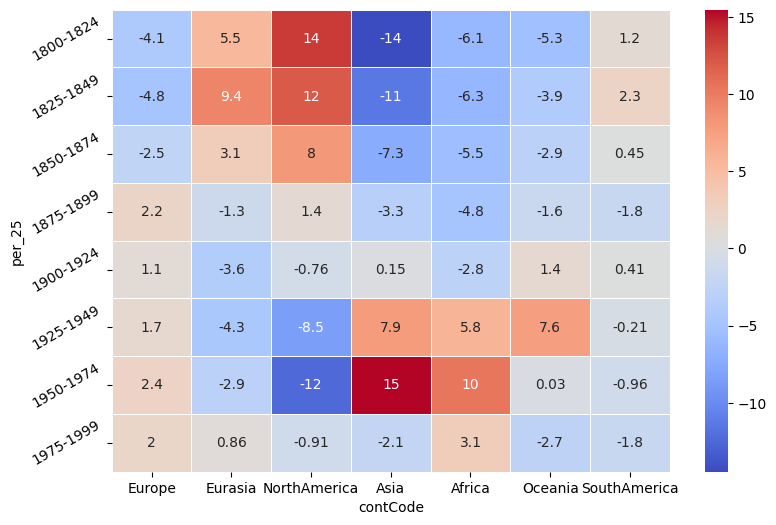

In [141]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)
plt.savefig('../images/continent_bivariee.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()



### En excluant l'Europe ou choisissant les pays

In [105]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1800-1824,21,1282,5,9,10,86
1825-1849,32,1274,57,9,21,99
1850-1874,17,1303,144,20,33,94
1875-1899,5,1219,237,31,49,83
1900-1924,0,1658,426,75,102,150
1925-1949,1,2260,881,240,232,229
1950-1974,5,1638,923,257,117,178
1975-1999,2,132,23,18,0,6


In [106]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 1808.71 , dof : 35
p-value : 0.0
phi2 = inertie (variance totale) : 0.06250285266277539
Cramer:  0.15182601256561576


In [107]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1800-1824,942,5,21,1282,86
1825-1849,960,57,32,1274,99
1850-1874,1197,144,17,1303,94
1875-1899,1527,237,5,1219,83
1900-1924,2129,426,0,1658,150
1925-1949,3420,881,1,2260,229
1950-1974,2867,923,5,1638,178
1975-1999,203,23,2,132,6


In [108]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 202.98 , dof : 7
p-value : 2.6790468547984653e-40
phi2 = inertie (variance totale) : 0.007014417043902401
Cramer:  0.12340920534554618


## Continent et genre

In [109]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe,1875-1899,Europe_male,other,Europe_other
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania,1950-1974,Oceania_female,other,Oceania_other
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,,Asia,1950-1974,Asia_male,other,Asia_other
3,http://www.wikidata.org/entity/Q1170754,Tielman Roos,1879,male,South Africa,Africa,"politician, judge, lawyer",,Africa,1875-1899,Africa_male,other,Africa_other
4,http://www.wikidata.org/entity/Q5080447,Charles M. Cooke,1844,male,United States,North America,"politician, judge, lawyer",,NorthAmerica,1825-1849,NorthAmerica_male,other,NorthAmerica_other


In [110]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,184,274,3,1320,1189,84,85,3139
male,486,2431,80,11967,9581,481,841,25867
Total,670,2705,83,13287,10770,565,926,29006


### Créer la fonction

In [149]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    plt.show()

In [112]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,184,274,3,1320,1189,84,85
male,486,2431,80,11967,9581,481,841


Chi2 : 221.6 , dof : 6
p-value : 4.7408897978616204e-45
phi2 = inertie (variance totale) : 0.007657783445403186
Cramer:  0.08740612666074868


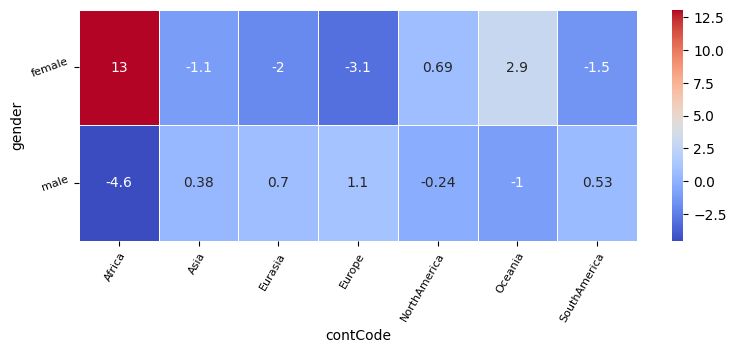

In [113]:
bivariee_stats(D)

### Genre et continent par époque

In [114]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe,1875-1899,Europe_male,other,Europe_other
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania,1950-1974,Oceania_female,other,Oceania_other
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,,Asia,1950-1974,Asia_male,other,Asia_other
3,http://www.wikidata.org/entity/Q1170754,Tielman Roos,1879,male,South Africa,Africa,"politician, judge, lawyer",,Africa,1875-1899,Africa_male,other,Africa_other
4,http://www.wikidata.org/entity/Q5080447,Charles M. Cooke,1844,male,United States,North America,"politician, judge, lawyer",,NorthAmerica,1825-1849,NorthAmerica_male,other,NorthAmerica_other


In [115]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1800-1824,0,9,0,5,0,21,0,942,2,1280,0,10,0,86,2355
1825-1849,0,9,0,57,0,32,0,960,0,1274,0,21,0,99,2452
1850-1874,0,20,0,144,1,16,2,1195,7,1296,0,33,0,94,2808
1875-1899,0,31,2,235,0,5,16,1511,27,1192,1,48,0,83,3151
1900-1924,3,72,23,403,0,0,74,2055,67,1590,1,101,9,141,4539
1925-1949,45,195,76,805,0,1,328,3091,352,1908,29,203,28,201,7262
1950-1974,119,138,165,758,1,4,806,2060,667,969,52,65,47,131,5982
1975-1999,15,3,7,16,1,1,85,118,64,68,0,0,1,5,384
Total,182,477,273,2423,3,80,1311,11932,1186,9577,83,481,85,840,28933


In [139]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[4:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,,,
1900-1924,3,72,23,403,0,0,74,2055,67,1590,1,101,9,141
1925-1949,45,195,76,805,0,1,328,3091,352,1908,29,203,28,201
1950-1974,119,138,165,758,1,4,806,2060,667,969,52,65,47,131
1975-1999,15,3,7,16,1,1,85,118,64,68,0,0,1,5


Chi2 : 2158.89 , dof : 39
p-value : 0.0
phi2 = inertie (variance totale) : 0.07460408436888713
Cramer:  0.19902760776077333


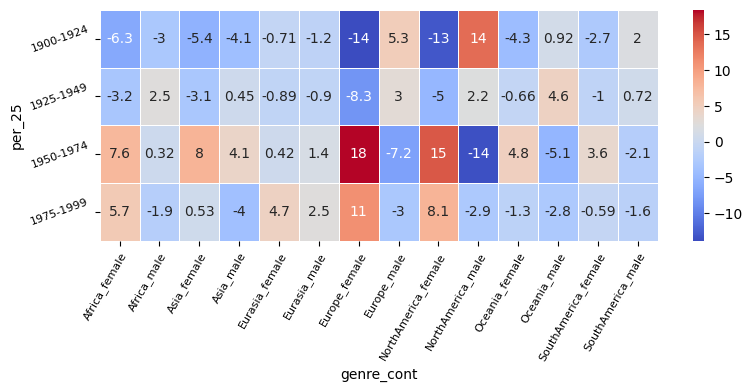

In [148]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [118]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

1320


In [119]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
United Kingdom                359
Germany                       313
Poland                         62
Spain                          58
Estonia                        43
Norway                         42
Sweden                         38
Austria                        32
Kingdom of the Netherlands     27
Slovenia                       22
dtype: int64


In [143]:
print(df_pef[df_pef.per_25 == '1975-1999'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
Germany           15
United Kingdom    13
Russia            10
Estonia            8
Georgia            6
Spain              5
Ukraine            5
Poland             5
France             4
Slovenia           3
dtype: int64


In [144]:
fff = df_pef[(df_pef.per_25 == '1975-1999') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

15


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
6121,http://www.wikidata.org/entity/Q113738475,Jacqueline Kempfer,1978,female,Germany,Europe,"jurist, judge",,Europe,1975-1999,Europe_female,other,Europe_other
6669,http://www.wikidata.org/entity/Q131358218,Lilian Stybel,1982,female,Germany,Europe,judge,,Europe,1975-1999,Europe_female,other,Europe_other
6746,http://www.wikidata.org/entity/Q27832243,Saskia Lettmaier,1979,female,Germany,Europe,"judge, university teacher, jurist","civil law, common law, legal history",Europe,1975-1999,Europe_female,other,Europe_other
8904,http://www.wikidata.org/entity/Q6537692,Kathrin Wahlmann,1977,female,Germany,Europe,"politician, judge",,Europe,1975-1999,Europe_female,other,Europe_other
10680,http://www.wikidata.org/entity/Q108754671,Sonja Eichwede,1987,female,Germany,Europe,"politician, judge",,Europe,1975-1999,Europe_female,other,Europe_other


## Continent et discipline

In [145]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe,1875-1899,Europe_male,other,Europe_other
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania,1950-1974,Oceania_female,other,Oceania_other
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,,Asia,1950-1974,Asia_male,other,Asia_other
3,http://www.wikidata.org/entity/Q1170754,Tielman Roos,1879,male,South Africa,Africa,"politician, judge, lawyer",,Africa,1875-1899,Africa_male,other,Africa_other
4,http://www.wikidata.org/entity/Q5080447,Charles M. Cooke,1844,male,United States,North America,"politician, judge, lawyer",,NorthAmerica,1825-1849,NorthAmerica_male,other,NorthAmerica_other


In [123]:
def code_discipline(col1, col2):
    if  'astronomer' in col1\
        or 'astronomy' in col2:
        output = 'astronomy'
    elif 'physicist' in col1\
        or 'physics' in col2:
        output = 'physics'
    else:
        output = 'other'
    return output    


In [124]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe,1875-1899,Europe_male,other,Europe_other
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania,1950-1974,Oceania_female,other,Oceania_other
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,male,South Korea,Asia,judge,,Asia,1950-1974,Asia_male,other,Asia_other
3,http://www.wikidata.org/entity/Q1170754,Tielman Roos,1879,male,South Africa,Africa,"politician, judge, lawyer",,Africa,1875-1899,Africa_male,other,Africa_other
4,http://www.wikidata.org/entity/Q5080447,Charles M. Cooke,1844,male,United States,North America,"politician, judge, lawyer",,NorthAmerica,1825-1849,NorthAmerica_male,other,NorthAmerica_other


In [126]:
df_p.groupby('code_discipline').size()

code_discipline
astronomy        5
other        29001
physics          5
dtype: int64

In [127]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
astronomy,0,0,0,4,1,0,0,5
other,670,2704,83,13279,10769,565,926,28996
physics,0,1,0,4,0,0,0,5
Total,670,2705,83,13287,10770,565,926,29006


In [128]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
astronomy,0.0,0.0,0.0,80.0,20.0,0.0,0.0,100.0
other,2.3,9.3,0.3,45.8,37.1,1.9,3.2,100.0
physics,0.0,20.0,0.0,80.0,0.0,0.0,0.0,100.0
Total,2.3,9.3,0.3,45.8,37.1,1.9,3.2,100.0


In [129]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


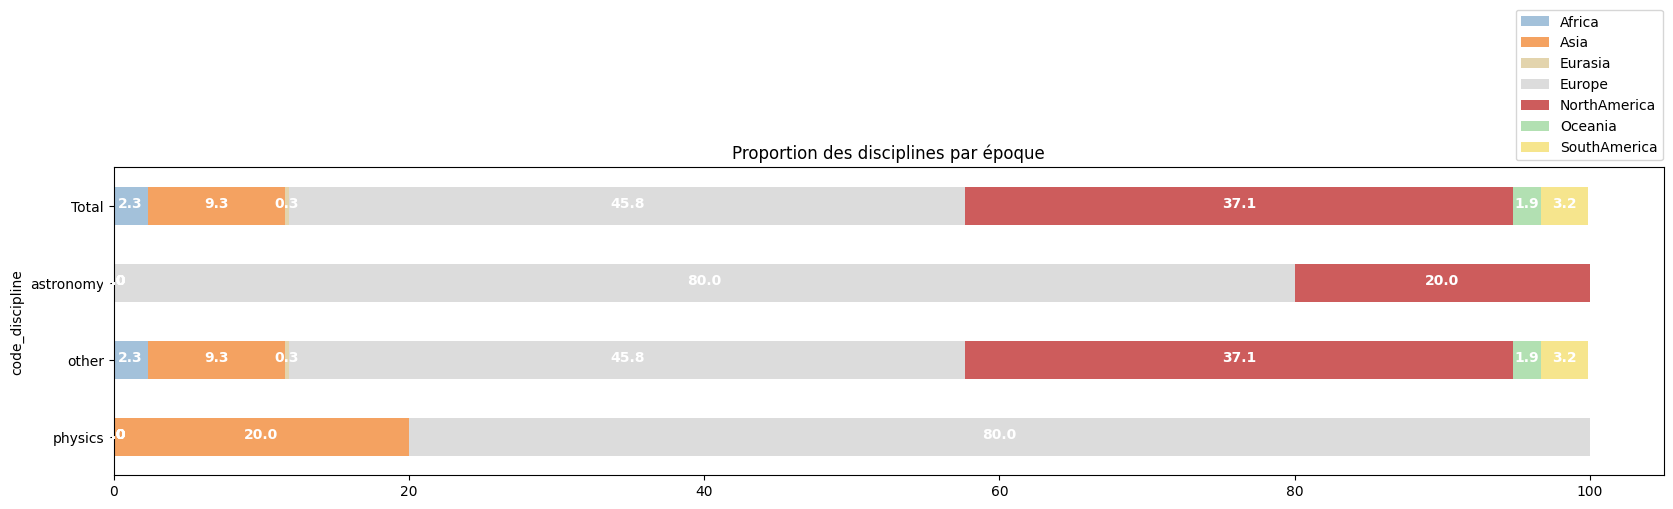

In [130]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [131]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
astronomy,0,0,0,4,1,0,0
other,670,2704,83,13279,10769,565,926
physics,0,1,0,4,0,0,0


Chi2 : 6.66 , dof : 12
p-value : 0.8794523435468301
phi2 = inertie (variance totale) : 0.00023002724859950564
Cramer:  0.010711862254832174


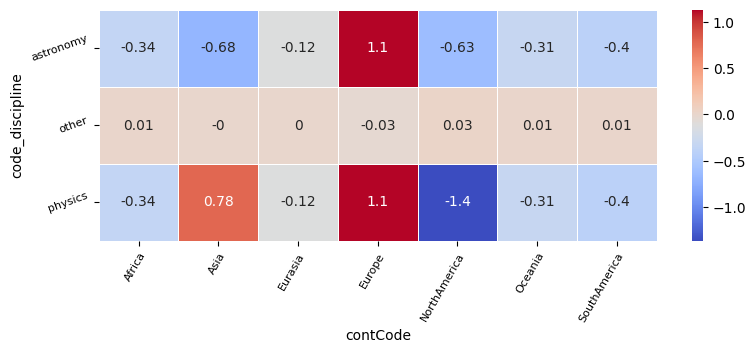

In [132]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [133]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe,1875-1899,Europe_male,other,Europe_other
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania,1950-1974,Oceania_female,other,Oceania_other


In [134]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,male,United Kingdom,Europe,"politician, judge",,Europe,1875-1899,Europe_male,other,Europe_other
1,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,female,Australia,Oceania,judge,,Oceania,1950-1974,Oceania_female,other,Oceania_other


In [135]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_other,Asia_other,Asia_physics,Eurasia_other,Europe_astronomy,Europe_other,Europe_physics,NorthAmerica_astronomy,NorthAmerica_other,Oceania_other,SouthAmerica_other,Total
per_25,,,,,,,,,,,,
1800-1824,9,5,0,21,1,940,1,0,1282,10,86,2355
1825-1849,9,57,0,32,0,959,1,1,1273,21,99,2452
1850-1874,20,144,0,17,1,1196,0,0,1303,33,94,2808
1875-1899,31,236,1,5,1,1525,1,0,1219,49,83,3151
1900-1924,75,426,0,0,1,2128,0,0,1657,102,150,4539
1925-1949,240,881,0,1,0,3419,0,0,2260,232,229,7262
1950-1974,257,923,0,5,0,2866,0,0,1636,117,178,5982
1975-1999,18,23,0,2,0,203,0,0,132,0,6,384
Total,659,2695,1,83,4,13236,3,1,10762,564,925,28933


In [137]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[4:-1,:-1].copy(deep=True)
D


disc_cont,Africa_other,Asia_other,Asia_physics,Eurasia_other,Europe_astronomy,Europe_other,Europe_physics,NorthAmerica_astronomy,NorthAmerica_other,Oceania_other,SouthAmerica_other
per_25,,,,,,,,,,,
1900-1924,75,426,0,0,1,2128,0,0,1657,102,150
1925-1949,240,881,0,1,0,3419,0,0,2260,232,229
1950-1974,257,923,0,5,0,2866,0,0,1636,117,178
1975-1999,18,23,0,2,0,203,0,0,132,0,6


In [138]:
## Appliquer la fonction
bivariee_stats(D)

ValueError: The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(2)).